In [1]:
!pip install -q lifelines
!pip install -q xgbse


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: /usr/local/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: /usr/local/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip


# Survival Analysis Regression

In this notebook, we use a dataset on commercial airline flights from 2018 and fit a Cox PH regression model. Further analysis is done including the use of a new metric to measure predicted landing time error discrepenancies and cases where the measure fails. This notebook uses the lifelines package for survival analysis methods.

# Table of Contents
1. [Data Loading](#data-loading)
2. [Data Exploration](#data-exploration)
3. [Data Preprocessing](#data-preprocessing)
4. [Analysis and Visualization](#analysis-and-visualization)
5. [Weibull and CV (Not implemented)](#weibull)

# Data Loading <a name="data-loading"></a>

### Import Libraries

In [68]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.utils import concordance_index

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold

from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation,concordance_index
from lifelines import CoxPHFitter, WeibullAFTFitter,LogNormalAFTFitter

from xgbse.metrics import dist_calibration_score
import sys
sys.path.append('../')
from survival_analysis import new_metric, new_metric_interp
import re 
import seaborn as sns
import matplotlib as mpl

### Loading Dataset

In [69]:
df=pd.read_csv("../dataset/data_survival_delay_2018-2.csv")

# Data Exploration <a name="data-exploration"></a>

### Filter to 9E airline

In [70]:
df_9E = df[df.Reporting_Airline == '9E'].copy()

In [71]:
df_9E.columns

Index(['Year', 'Quarter', 'Month', 'Weekend', 'FlightDate',
       'Reporting_Airline', 'CRSDepTime', 'DepTime', 'CRSArrTime', 'ArrTime',
       'Origin', 'Dest', 'ArrDelay', 'ArrDelayMinutes', 'DepDelay',
       'DepDelayMinutes', 'TaxiOut', 'AirTime', 'TaxiIn', 'CRSElapsedTime',
       'ActualElapsedTime', 'AircraftType', 'AircraftAge',
       'AircraftManufacturer', 'AircraftModel', 'Distance', 'DistanceGroup',
       'CarrierDelay', 'WeatherDelay', 'NASDelay', 'ArrivalDelayGroups',
       'DepDel15', 'ArrDel15', 'WheelsOff', 'WheelsOn', 'Tail_Number',
       'FlightSequenceTails'],
      dtype='object')

In [72]:
df_9E.head()

,Year,Quarter,Month,Weekend,FlightDate,Reporting_Airline,CRSDepTime,DepTime,CRSArrTime,ArrTime,...,CarrierDelay,WeatherDelay,NASDelay,ArrivalDelayGroups,DepDel15,ArrDel15,WheelsOff,WheelsOn,Tail_Number,FlightSequenceTails
4756727,2018,1,1,0,2018-01-23,9E,1202,1157.0,1304,1256.0,...,NaN,NaN,NaN,-1.0,0.0,0.0,1211.0,1249.0,N8928A,1
4756728,2018,1,1,0,2018-01-24,9E,1202,1157.0,1304,1258.0,...,NaN,NaN,NaN,-1.0,0.0,0.0,1210.0,1246.0,N800AY,1
4756729,2018,1,1,0,2018-01-25,9E,1202,1153.0,1304,1302.0,...,NaN,NaN,NaN,-1.0,0.0,0.0,1211.0,1251.0,N8836A,1
4756730,2018,1,1,0,2018-01-26,9E,1202,1150.0,1304,1253.0,...,NaN,NaN,NaN,-1.0,0.0,0.0,1207.0,1242.0,N800AY,1
4756731,2018,1,1,1,2018-01-27,9E,1400,1355.0,1500,1459.0,...,NaN,NaN,NaN,-1.0,0.0,0.0,1412.0,1448.0,N8839E,1


### Filter columns

In [73]:
selected_columns = [ 
    
    #Time based features 
    'Month','FlightDate',
    
    # Airline based features 
    'Reporting_Airline',
    'AircraftAge',
    'AircraftModel',

    # Route based 
    'Origin','Dest','Distance',

    # Departure and Arrival based features 
    'DepTime',
    'CRSDepTime',
    'CRSArrTime','ActualElapsedTime','DepDelay',
    
    #Block Time 
    'CRSElapsedTime',
    'Weekend',

    # Delay at arrival (Time to event)
    'ArrDelay',
                    ]
# Filtering selected columns 
df_9E = df_9E[selected_columns]
df_9E.head()

,Month,FlightDate,Reporting_Airline,AircraftAge,AircraftModel,Origin,Dest,Distance,DepTime,CRSDepTime,CRSArrTime,ActualElapsedTime,DepDelay,CRSElapsedTime,Weekend,ArrDelay
4756727,1,2018-01-23,9E,14,CL-600-2B19,ABY,ATL,145.0,1157.0,1202,1304,59.0,-5.0,62.0,0,-8.0
4756728,1,2018-01-24,9E,14,CL-600-2B19,ABY,ATL,145.0,1157.0,1202,1304,61.0,-5.0,62.0,0,-6.0
4756729,1,2018-01-25,9E,15,CL-600-2B19,ABY,ATL,145.0,1153.0,1202,1304,69.0,-9.0,62.0,0,-2.0
4756730,1,2018-01-26,9E,14,CL-600-2B19,ABY,ATL,145.0,1150.0,1202,1304,63.0,-12.0,62.0,0,-11.0
4756731,1,2018-01-27,9E,15,CL-600-2B19,ABY,ATL,145.0,1355.0,1400,1500,64.0,-5.0,60.0,1,-1.0


### Correlation Heat map

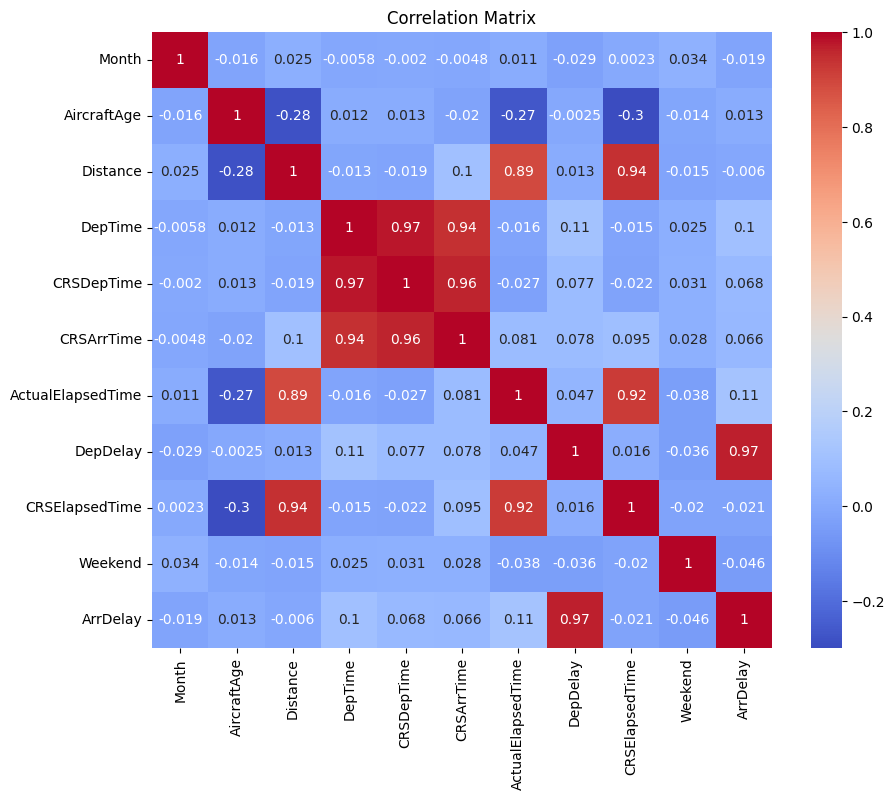

In [74]:
correlation_matrix = df_9E.corr(numeric_only = True)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Data Preprocessing <a name="data-preprocessing"></a>

### Remove NANs

In [75]:
df_9E.dropna(inplace=True)

### Add feature link

In [76]:
df_9E['Link'] = df_9E['Origin'] + '-' + df_9E['Dest']

### Add Event column for survival analysis

In [77]:
df_9E['Event'] = 1

### Add Time column for survival analysis

In [78]:
df_9E['Time'] = df_9E.apply(lambda x: x['CRSElapsedTime'] + x['ArrDelay'], axis=1)

# Old time measure no longer using
#df_9E_link1['Time'] = df_9E_link1.apply(lambda x: x['ArrDelay'], axis=1)

### New hour arrival feature

In [79]:
df_9E['S_Hour_arrival'] = df_9E['CRSArrTime'] // 100
df_9E.head()

,Month,FlightDate,Reporting_Airline,AircraftAge,AircraftModel,Origin,Dest,Distance,DepTime,CRSDepTime,CRSArrTime,ActualElapsedTime,DepDelay,CRSElapsedTime,Weekend,ArrDelay,Link,Event,Time,S_Hour_arrival
4756727,1,2018-01-23,9E,14,CL-600-2B19,ABY,ATL,145.0,1157.0,1202,1304,59.0,-5.0,62.0,0,-8.0,ABY-ATL,1,54.0,13
4756728,1,2018-01-24,9E,14,CL-600-2B19,ABY,ATL,145.0,1157.0,1202,1304,61.0,-5.0,62.0,0,-6.0,ABY-ATL,1,56.0,13
4756729,1,2018-01-25,9E,15,CL-600-2B19,ABY,ATL,145.0,1153.0,1202,1304,69.0,-9.0,62.0,0,-2.0,ABY-ATL,1,60.0,13
4756730,1,2018-01-26,9E,14,CL-600-2B19,ABY,ATL,145.0,1150.0,1202,1304,63.0,-12.0,62.0,0,-11.0,ABY-ATL,1,51.0,13
4756731,1,2018-01-27,9E,15,CL-600-2B19,ABY,ATL,145.0,1355.0,1400,1500,64.0,-5.0,60.0,1,-1.0,ABY-ATL,1,59.0,15


### Add Circular time features

In [80]:
#change time to minutes
df_9E['CRSDepTime'] = df_9E['CRSDepTime'].apply(lambda x: (x//100)*60 + x%100)
df_9E['CRSArrTime'] = df_9E['CRSArrTime'].apply(lambda x: (x//100)*60 + x%100)

#circular time
minutes_in_day = 24*60

df_9E['CRSDepTime_sin'] = np.sin(2*np.pi*df_9E['CRSDepTime']/minutes_in_day)
df_9E['CRSDepTime_cos'] = np.cos(2*np.pi*df_9E['CRSDepTime']/minutes_in_day)
df_9E['CRSArrTime_sin'] = np.sin(2*np.pi*df_9E['CRSArrTime']/minutes_in_day)
df_9E['CRSArrTime_cos'] = np.cos(2*np.pi*df_9E['CRSArrTime']/minutes_in_day)

### One hot encoding

In [81]:
columns_to_encode = ['Origin', 'Dest'] # Categorical variables   ( # S_Hour_arrival)   # 'Quarter', 'Month',
df_encoded = df_9E

# Perform one-hot encoding
for col in columns_to_encode:
    df_encoded = pd.get_dummies(df_encoded, columns=[col], drop_first = True)

#Dropping origin , dest and link  & AircraftModel & Reporting_Airline
df_encoded.drop(columns=['Link','AircraftModel','Reporting_Airline', 'ActualElapsedTime'],inplace=True)

# Dropping the old columns 
df_encoded.drop(columns=['FlightDate','Distance', 'ArrDelay','CRSDepTime','CRSArrTime','DepDelay', 'DepTime','CRSElapsedTime',],inplace=True)

df_encoded.dropna(inplace=True)

# Analysis and Visualization <a name="analysis-and-visualization"></a>

### Adding epsilon to time

In [82]:
epsilon = 0.01
df_encoded["Time_1"] = df_encoded["Time"] + epsilon
df_encoded.drop(columns=['Time'],inplace=True)

### Plotting the K-M estimate for delay data  

In [83]:
df_encoded['S_Hour_arrival'].value_counts()

11    7243
14    7062
13    6616
9     6485
16    6475
18    6307
17    6204
21    5714
12    5635
10    5529
20    5455
15    5211
19    4763
8     4528
22    4413
7     4316
23    3237
6      298
0      185
1        3
5        1
Name: S_Hour_arrival, dtype: int64

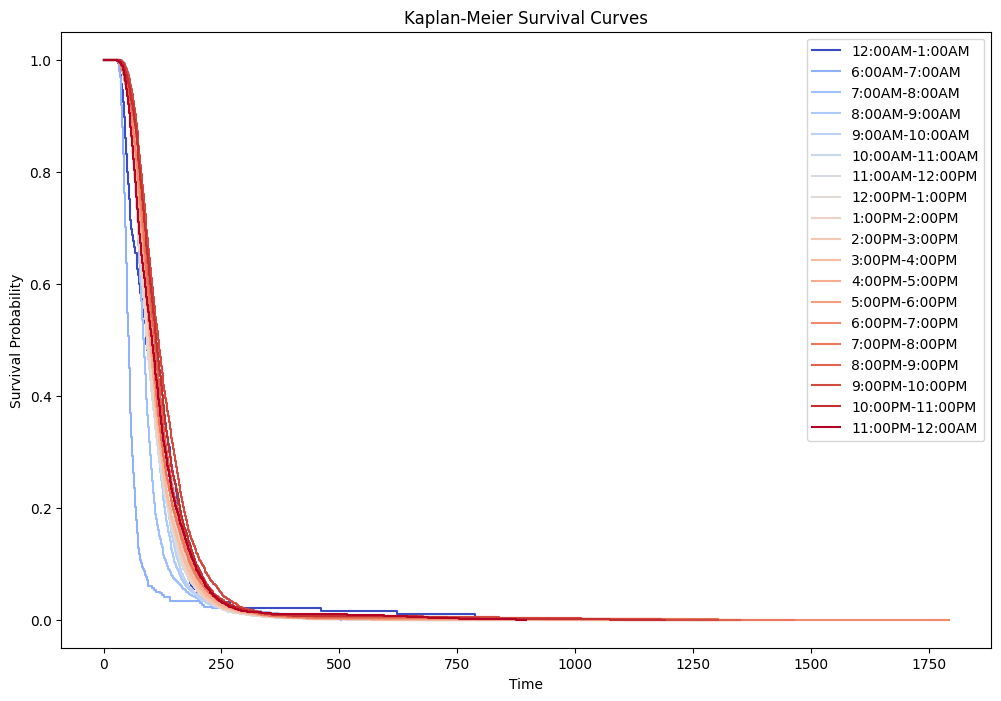

In [84]:
def to_12_hour(hour):
    """Convert 24-hour format to 12-hour format with AM/PM."""
    if hour == 0:
        return '12:00AM'
    elif hour == 12:
        return '12:00PM'
    elif hour > 12:
        return f"{hour % 12}:00PM"
    else:
        return f"{hour}:00AM"

# Setup the figure
plt.figure(figsize=(12,8))

# Compute the counts for each unique S_Hour_arrival value
arrival_counts = df_encoded['S_Hour_arrival'].value_counts()

# Set a threshold
threshold = 20

# Filter the S_Hour_arrival values based on the threshold
filtered_arrival_values = arrival_counts[arrival_counts > threshold].index.tolist()
filtered_arrival_values = sorted(filtered_arrival_values)

# Set up colormap and normalization
colormap = plt.cm.coolwarm
norm = mpl.colors.Normalize(vmin=min(filtered_arrival_values), vmax=max(filtered_arrival_values))

# Create a KaplanMeierFitter object
kmf = KaplanMeierFitter()

# Fit the survival function for each S_Hour_arrival value and plot the curves
for S_Hour_arrival in filtered_arrival_values:
    # Subset the data based on the S_Hour_arrival value
    subset_data = df_encoded[df_encoded['S_Hour_arrival'] == S_Hour_arrival]

    # Fit the survival function
    kmf.fit(subset_data['Time_1'], event_observed=subset_data['Event'])

    # Get color from the colormap
    color = colormap(norm(S_Hour_arrival))

    # Plot the survival function curve with the new label format
    label = f"{to_12_hour(S_Hour_arrival)}-{to_12_hour((S_Hour_arrival + 1) % 24)}"
    kmf.plot_survival_function(label=label, ci_show=False, color=color)

# Add labels and legends
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title(f'Kaplan-Meier Survival Curves')
plt.legend()

# Show the plot
plt.show()

### Train Test split

In [85]:
train_df , test_df = train_test_split(df_encoded, 
                                      test_size=0.2, 
                                      random_state=42)

### Cox PH 

In [86]:
cph = CoxPHFitter()
cph.fit(train_df, duration_col='Time_1', event_col='Event', strata=['Month'])

<lifelines.CoxPHFitter: fitted with 76544 total observations, 0 right-censored observations>

In [87]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 76544 total observations, 0 right-censored observations>
             duration col = 'Time_1'
                event col = 'Event'
                   strata = Month
      baseline estimation = breslow
   number of observations = 76544
number of events observed = 76544
   partial log-likelihood = -649042.01
         time fit was run = 2023-12-12 21:42:03 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
AircraftAge      0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
Weekend          0.16       1.17       0.01             0.14             0.17                 1.15                 1.19
S_Hour_arrival  -0.02       0.98       0.00            -0.02            -0.01                 0.98                 0.99
CRSDepTime_sin  -0.96       0.38       0.04            -1.03            -0.89                 0.36                 0.41
CRSDepTime_cos   0.23       1.26       0.03             0.17             0.28                 1.19                 1.33
CRSArrTime_sin   0.73       2.08       0.03             0.67             0.79                 1.96                 2.21
CRSArrTime_cos  -0.72       0.48       0.04            -0.79            -0.65                 0.45                 0.52
Origin_ABY       1.49       4.45       0.12             1.26             1.72                 3.54                 5.59
Origin_AEX       0.54       1.72       0.10             0.35             0.73                 1.42                 2.07
Origin_AGS       1.16       3.19       0.09             0.97             1.34                 2.65                 3.83
Origin_ALB       0.53       1.70       0.18             0.17             0.89                 1.18                 2.44
Origin_ATL       0.96       2.60       0.09             0.78             1.13                 2.18                 3.11
Origin_ATW       0.79       2.19       0.11             0.58             0.99                 1.78                 2.70
Origin_AUS       0.03       1.03       0.13            -0.22             0.29                 0.80                 1.33
Origin_AVL       1.22       3.39       0.13             0.97             1.48                 2.64                 4.37
Origin_AVP       0.68       1.97       0.14             0.41             0.94                 1.51                 2.57
Origin_AZO      -0.49       0.61       0.46            -1.38             0.40                 0.25                 1.50
Origin_BDL       0.21       1.23       0.10             0.01             0.41                 1.01                 1.51
Origin_BGR       0.85       2.34       0.10             0.66             1.05                 1.93                 2.85
Origin_BHM       0.50       1.65       0.11             0.27             0.72                 1.32                 2.06
Origin_BIS       1.45       4.26       0.19             1.08             1.82                 2.94                 6.17
Origin_BMI       0.45       1.57       0.10             0.25             0.65                 1.29                 1.91
Origin_BNA       0.36       1.43       0.10             0.17             0.55                 1.19                 1.74
Origin_BOS       0.26       1.29       0.09             0.08             0.43                 1.09                 1.54
Origin_BQK       1.30       3.65       0.12             1.06             1.53                 2.89                 4.61
Origin_BTR       0.88       2.41       0.10             0.68             1.07                 1.98                 2.93
Origin_BTV       0.43       1.54       0.09             0.26             0.61                 1.29                 1.83
Origin_BUF       0.98       2.66       0.09             0.80             1.16                 2.23                 3.18


In [88]:
cph.check_assumptions(train_df)

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 76544 total observations, 0 right-censored observations>
         test_name = proportional_hazard_test

---
                     test_statistic      p  -log2(p)
AircraftAge    km             41.42 <0.005     32.92
               rank           11.75 <0.005     10.68
CRSArrTime_cos km            232.53 <0.005    172.00
               rank           17.85 <0.005     15.35
CRSArrTime_sin km            379.66 <0.005    278.48
               rank            2.78   0.10      3.39
CRSDepTime_cos km             98.24 <0.005     74.51
               rank           46.91 <0.005     36.97
CRSDepTime_sin km            500.99 <0.005    366.20
               rank           23.20 <0.005     19.39
Dest_ABY       km            242.94 <0.005    179.53
               rank            1.82   0.18      2.50
Dest_AEX       km              2.63   0.10      3.26
               rank            0.29   0.59      0.77
Dest_AGS       km            372.31 <0.005    273.17
               rank           27.92 <0.005     22.91
Dest_ALB       km             15.72 <0.005     13.73
               rank            0.52   0.47      1.09
Dest_ATL       km            261.28 <0.005    192.82
               rank           14.70 <0.005     12.96
Dest_ATW       km             73.68 <0.005     56.59
               rank           14.58 <0.005     12.86
Dest_AUS       km              6.60   0.01      6.62
               rank            0.05   0.82      0.28
Dest_AVL       km            122.36 <0.005     92.07
               rank            4.96   0.03      5.27
Dest_AVP       km             90.02 <0.005     68.53
               rank            7.13   0.01      7.05
Dest_AZO       km             29.13 <0.005     23.82
               rank            2.53   0.11      3.16
Dest_BDL       km             79.55 <0.005     60.88
               rank            1.37   0.24      2.04
Dest_BGR       km            170.61 <0.005    127.11
               rank            5.10   0.02      5.39
Dest_BHM       km             39.82 <0.005     31.74
               rank            0.01   0.92      0.11
Dest_BIS       km             34.45 <0.005     27.77
               rank            0.02   0.88      0.19
Dest_BMI       km             10.73 <0.005      9.89
               rank            0.01   0.93      0.10
Dest_BNA       km             12.44 <0.005     11.21
               rank            0.35   0.55      0.85
Dest_BOS       km            161.69 <0.005    120.64
               rank            2.14   0.14      2.80
Dest_BQK       km            135.09 <0.005    101.32
               rank            2.71   0.10      3.33
Dest_BTR       km              7.44   0.01      7.30
               rank            1.71   0.19      2.39
Dest_BTV       km            161.30 <0.005    120.35
               rank            7.78   0.01      7.57
Dest_BUF       km            184.52 <0.005    137.20
               rank            3.48   0.06      4.01
Dest_BWI       km            278.76 <0.005    205.48
               rank           12.28 <0.005     11.09
Dest_CAE       km            143.88 <0.005    107.70
               rank            9.72 <0.005      9.10
Dest_CAK       km             25.01 <0.005     20.74
               rank           14.61 <0.005     12.88
Dest_CHA       km            331.19 <0.005    243.42
               rank            9.78 <0.005      9.15
Dest_CHO       km             38.36 <0.005     30.66
               rank            2.85   0.09      3.45
Dest_CHS       km             23.98 <0.005     19.97
               rank            0.71   0.40      1.33
Dest_CID       km              1.98   0.16      2.65
               rank            0.05   0.82      0.29
Dest_CLE       km            159.62 <0.005    119.14
               rank            1.32   0.25      1.99
Dest_CLT       km             61.62 <0.005     47.77
             



1. Variable 'AircraftAge' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'AircraftAge' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'AircraftAge' using pd.cut, and then specify it in
`strata=['AircraftAge', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'Weekend' failed the non-proportional test: p-value is 0.0088.

   Advice: with so few unique values (only 2), you can include `strata=['Weekend', ...]` in the call
in `.fit`. See documentation in link [E] below.

3. Variable 'S_Hour_arrival' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form 

[]

## Metrics

### Predicted and actual times

In [89]:
predicted_times = cph.predict_median(test_df)
actual_times = test_df["Time_1"]

### C-index

In [90]:
concordance_index(actual_times, predicted_times, test_df['Event'])

0.7330492183688048

### MAE

In [91]:
abs_diff = (predicted_times - actual_times).abs()
abs_diff.mean()

29.871132943143813

### MSE

In [92]:
square_diff = (predicted_times - actual_times)**2
square_diff.mean()

3486.745610367893

### New Metric

In [93]:
counts, bad_idx = new_metric(test_df, df_9E, cph)
counts

{'within': 7046,
 'within_pct': 0.3755863539445629,
 'mae': 65.87742548964705,
 'mae_above': 40.46677146312517,
 'mae_below': 34.960949720669795,
 'above_count': 9924,
 'below_count': 1790,
 'inf_count': 376}

### New Metric with Interpolation

Note CoxPH is a semiparametric model so its returned survival curves are not smooth

In [94]:
new_metric_interp(test_df,df_9E,cph.predict_survival_function(test_df).transpose())

{'within': 4506,
 'within_pct': 0.23559552441702394,
 'mae': 66.58330454893859,
 'mae_above': 74.26046564353095,
 'mae_below': 52.109272589862044,
 'above_count': 9553,
 'below_count': 5067,
 'inf_count': 10}

### D-Calibration

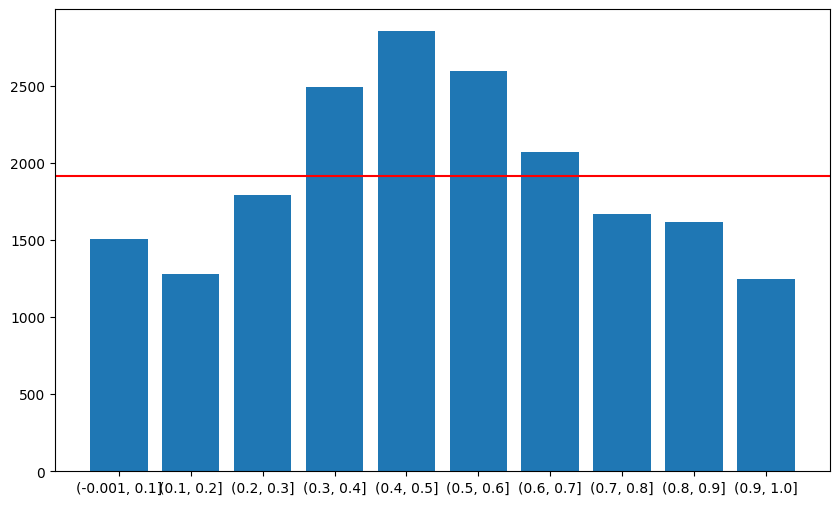

In [95]:
ytrue = test_df[['Event', 'Time_1']].sort_index().to_records(index=False)
survival = cph.predict_survival_function(test_df).transpose().sort_index()
res = dist_calibration_score(ytrue, survival, returns='histogram')
plt.figure(figsize=(10,6))
plt.bar(res.index.to_numpy().astype(str),res)
plt.axhline(y=1913, color='r', linestyle='-')

## Infinity Analysis

### Verify CRSElapsed times in test data are above the minimum arrival time in the full data

From the Kaplan-Meier estimates, the probability of survival for any time after the last recorded event is 0. In these cases, the percentile 1-p becomes 1 meaning we are looking for a time that survives longer than 100% of all observations. Since the curve the Cox outputs does not cross 0, the function returns infinity. We expect this to happen when the CRSElapsedTime is greater than all previous recorded arrival times. 
https://lifelines.readthedocs.io/en/latest/fitters/regression/CoxPHFitter.html#lifelines.fitters.coxph_fitter.SemiParametricPHFitter.predict_percentile

In [96]:
infs_df = df_9E.loc[bad_idx].sort_index()
count = []
smaller = 0
for name, grouped_df in infs_df.groupby(['S_Hour_arrival', 'Link']):
    subset = df_9E.loc[(df_9E['S_Hour_arrival'] == name[0]) & (df_9E['Link'] == name[1])]
    count.append(len(subset))
    max_time = subset['Time'].max()
    smaller += len(grouped_df.loc[grouped_df['CRSElapsedTime'] >= max_time])
smaller

376

### Number of flights with same hour of arrival and link

How many observations were used for the KM estimates for each hour arrival and link pair that resulted in infinity. As expected most of these flights only ran or a few times making it more likely that all the flights happened to have arrived late.

In [97]:
pd.Series(count).value_counts()

1     73
3     49
2     38
4     31
7     18
5     14
8     12
6     12
9      6
12     3
11     3
10     3
13     1
27     1
33     1
19     1
20     1
17     1
21     1
dtype: int64

### Bar plot of arrival hours

<Axes: >

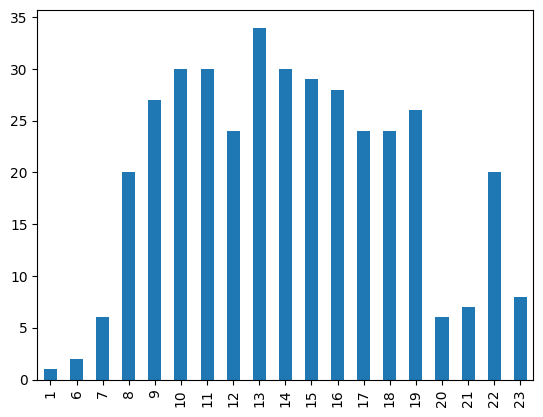

In [64]:
infs_df['S_Hour_arrival'].value_counts().sort_index().plot(kind='bar')

# Weibull and CV <a name="weibull"></a>

not using code here

### Weibull AFT

In [ ]:
# Fit the Weibull AFT model on the training data
weibull_aft = WeibullAFTFitter()
weibull_aft.fit(train_df, duration_col='Time_1', event_col='Event')

In [ ]:
weibull_aft.print_summary()

## Plotting the weibull 

In [ ]:
weibull_aft.plot_partial_effects_on_outcome(covariates='S_Hour_arrival', values=[5,10,16,24], cmap='coolwarm')

## Log normal AFT

In [ ]:
# Fit the LogNormal AFT model on the training data
lognormal_aft = LogNormalAFTFitter()
lognormal_aft.fit(train_df, duration_col='Time_1', event_col='Event')

In [ ]:
lognormal_aft.print_summary()

## CPH v AFT models using Lifelines

## With Startification

### 1. Stratify Data by the continuous data

In [ ]:
# Use a new dataframe after stratification
df_s1 = df_encoded.copy()
df_s1.rename(columns={'Time_1':'target'},inplace=True)

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

def create_folds(df, n_s=5, n_grp=None):
    df = df.reset_index(drop=True)  # Reset index to ensure continuous integer index
    df['Fold'] = -1
    
    if n_grp is None:
        skf = KFold(n_splits=n_s)
        target = df.target
    else:
        skf = StratifiedKFold(n_splits=n_s)
        df['grp'] = pd.cut(df.target, n_grp, labels=False)
        target = df.grp
    
    for fold_no, (t, v) in enumerate(skf.split(target, target)):
        df.loc[v, 'Fold'] = fold_no
    return df

df_s1 = create_folds(df_s1, n_s=5,n_grp=12)
df_s1.head()

In [ ]:
df_s1.shape

In [ ]:
pd.cut(df_s1.target, 12)

In [ ]:
plt.hist(df_s1['target'], bins=100, density=True)
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.show()

### 2. Check quality of the fold 

In [ ]:
# Checking the quality of folds 
import matplotlib.pyplot as plt

def plot_fold_histograms(data, target, fold_column='Fold'):
    n_folds = data[fold_column].nunique()
    fig, axs = plt.subplots(1, n_folds, figsize=(5*n_folds, 5))

    for i in range(n_folds):
        fold_data = data[data[fold_column] == i][target]
        axs[i].hist(fold_data, bins=30)
        axs[i].set_title(f'Fold {i+1} Target Distribution')

    plt.tight_layout()
    plt.show()

# Usage:
plot_fold_histograms(df_s1, 'target')


In [ ]:
def print_fold_statistics(data, target, fold_column='Fold'):
    n_folds = data[fold_column].nunique()

    for i in range(n_folds):
        fold_data = data[data[fold_column] == i][target]
        print(f'Fold {i+1} Mean: {fold_data.mean()}, Standard Deviation: {fold_data.std()}')

# Usage:
print_fold_statistics(df_s1, 'target')


### 3.K fold on the stratified dataset 

In [ ]:
# Empty lists to store the scores
concordance_scores_trn_cph = []
concordance_scores_test_cph = []
concordance_scores_trn_weibull = []
concordance_scores_test_weibull = []
concordance_scores_trn_lognormal = []
concordance_scores_test_lognormal=[]

# Find unique fold identifiers
unique_folds = df_s1['Fold'].unique()

# Iterate over each fold
for fold in unique_folds:
    # Create train and test datasets
    train_df = df_s1[df_s1['Fold'] != fold]
    test_df = df_s1[df_s1['Fold'] == fold]
    
    # Select features 
    train_df = train_df[['Month','S_Hour_arrival','target','Event','AircraftAge','CRSElapsedTime']]
    test_df = test_df[['Month','S_Hour_arrival','target','Event','AircraftAge','CRSElapsedTime']]

    # Fit the Cox PH model on the training data
    cph = CoxPHFitter()
    cph.fit(train_df, duration_col='target', event_col='Event', strata=['Month'])

    # Fit the Weibull AFT model on the training data
    weibull_aft = WeibullAFTFitter()
    weibull_aft.fit(train_df, duration_col='target', event_col='Event')
    
    # Fit the LogNormal AFT model on the training data
    lognormal_aft = LogNormalAFTFitter()
    lognormal_aft.fit(train_df, duration_col='target', event_col='Event')

    # Calculate concordance index (c-index) for train and test datasets for all models
    train_scores_cph = concordance_index(train_df['target'], -cph.predict_partial_hazard(train_df), train_df['Event'])
    test_scores_cph = concordance_index(test_df['target'], -cph.predict_partial_hazard(test_df), test_df['Event'])

    train_scores_weibull = concordance_index(train_df['target'], weibull_aft.predict_median(train_df), train_df['Event'])
    test_scores_weibull = concordance_index(test_df['target'], weibull_aft.predict_median(test_df), test_df['Event'])

    train_scores_lognormal = concordance_index(train_df['target'], lognormal_aft.predict_median(train_df), train_df['Event'])
    test_scores_lognormal = concordance_index(test_df['target'], lognormal_aft.predict_median(test_df), test_df['Event'])
    
    # Append the scores to the respective lists
    concordance_scores_trn_cph.append(train_scores_cph)
    concordance_scores_test_cph.append(test_scores_cph)

    concordance_scores_trn_weibull.append(train_scores_weibull)
    concordance_scores_test_weibull.append(test_scores_weibull)
    
    concordance_scores_trn_lognormal.append(train_scores_lognormal)
    concordance_scores_test_lognormal.append(test_scores_lognormal)

# Print the results
print("Cox PH Train Concordance Index Scores:")
print(concordance_scores_test_cph)

print("Cox PH Test Concordance Index Scores:")
print(concordance_scores_test_cph)

print("Weibull AFT Train Concordance Index Scores:")
print(concordance_scores_test_weibull)

print("Weibull AFT Test Concordance Index Scores:")
print(concordance_scores_test_weibull)


In [ ]:
print(f"CoxPH        : Train = {round(np.mean(concordance_scores_trn_cph),3)} ({round(np.std(concordance_scores_trn_cph),3)})     Test = {round(np.mean(concordance_scores_test_cph),3)} ({round(np.std(concordance_scores_test_cph),3)}) ")
print(f"Weibull AFT  : Train = {round(np.mean(concordance_scores_trn_weibull),3)} ({round(np.std(concordance_scores_trn_weibull),3)})     Test = {round(np.mean(concordance_scores_test_weibull),3)} ({round(np.std(concordance_scores_test_weibull),3)}) ")
print(f"Lognormal AFT: Train = {round(np.mean(concordance_scores_trn_lognormal),3)} ({round(np.std(concordance_scores_trn_lognormal),3)})      Test = {round(np.mean(concordance_scores_test_lognormal),3)} ({round(np.std(concordance_scores_test_lognormal),3)}) ")

In [ ]:
cph.print_summary()

In [ ]:
# Plot the graph of the scores 


## Without Stratification

In [574]:
# Use a new dataframe 
df_1 = df_encoded.copy()

In [575]:
# Define the number of folds for k-fold cross-validation
num_folds = 5

# Empty lists to store the c-index scores for each model
concordance_scores_trn_cph = []
concordance_scores_test_cph = []
concordance_scores_trn_weibull = []
concordance_scores_test_weibull = []
concordance_scores_trn_lognormal = []
concordance_scores_test_lognormal = []

# Define the KFold object
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform k-fold cross-validation for all models
for train_idx, test_idx in kf.split(df_1):
    # Get the training and test data using the indices
    train_df = df_1.iloc[train_idx]
    test_df = df_1.iloc[test_idx]
    
    # Select features 
    train_df = train_df[['Month','S_Hour_arrival','Time_1','Event','AircraftAge','CRSElapsedTime']]
    test_df = test_df[['Month','S_Hour_arrival','Time_1','Event','AircraftAge','CRSElapsedTime']]


    # Cox PH model
    cph = CoxPHFitter()
    cph.fit(train_df, duration_col='Time_1', event_col='Event', strata=['Month'])
    train_scores_cph = concordance_index(train_df['Time_1'], -cph.predict_partial_hazard(train_df), train_df['Event'])
    test_scores_cph = concordance_index(test_df['Time_1'], -cph.predict_partial_hazard(test_df), test_df['Event'])
    concordance_scores_trn_cph.append(train_scores_cph)
    concordance_scores_test_cph.append(test_scores_cph)

    # Weibull AFT model
    weibull_aft = WeibullAFTFitter()
    weibull_aft.fit(train_df, duration_col='Time_1', event_col='Event')
    train_scores_weibull = concordance_index(train_df['Time_1'], weibull_aft.predict_median(train_df), train_df['Event'])
    test_scores_weibull = concordance_index(test_df['Time_1'], weibull_aft.predict_median(test_df), test_df['Event'])
    concordance_scores_trn_weibull.append(train_scores_weibull)
    concordance_scores_test_weibull.append(test_scores_weibull)

    # LogNormal AFT model
    lognormal_aft = LogNormalAFTFitter()
    lognormal_aft.fit(train_df, duration_col='Time_1', event_col='Event')
    train_scores_lognormal = concordance_index(train_df['Time_1'], lognormal_aft.predict_median(train_df), train_df['Event'])
    test_scores_lognormal = concordance_index(test_df['Time_1'], lognormal_aft.predict_median(test_df), test_df['Event'])
    concordance_scores_trn_lognormal.append(train_scores_lognormal)
    concordance_scores_test_lognormal.append(test_scores_lognormal)

# Calculate the average c-index scores for each model
cph_train_avg_score = np.mean(concordance_scores_trn_cph)
cph_test_avg_score = np.mean(concordance_scores_test_cph)
weibull_train_avg_score = np.mean(concordance_scores_trn_weibull)
weibull_test_avg_score = np.mean(concordance_scores_test_weibull)
lognormal_train_avg_score = np.mean(concordance_scores_trn_lognormal)
lognormal_test_avg_score = np.mean(concordance_scores_test_lognormal)

# Print the average results for each model
print("Cox PH Train Concordance Index Score:", cph_train_avg_score)
print("Cox PH Test Concordance Index Score:", cph_test_avg_score)

print("Weibull AFT Train Concordance Index Score:", weibull_train_avg_score)
print("Weibull AFT Test Concordance Index Score:", weibull_test_avg_score)

print("LogNormal AFT Train Concordance Index Score:", lognormal_train_avg_score)
print("LogNormal AFT Test Concordance Index Score:", lognormal_test_avg_score)

NameError: name 'KFold' is not defined

In [ ]:
print(f"CoxPH        : Train = {round(np.mean(concordance_scores_trn_cph),3)} ({round(np.std(concordance_scores_trn_cph),3)})     Test = {round(np.mean(concordance_scores_test_cph),3)} ({round(np.std(concordance_scores_test_cph),3)}) ")
print(f"Weibull AFT  : Train = {round(np.mean(concordance_scores_trn_weibull),3)} ({round(np.std(concordance_scores_trn_weibull),3)})     Test = {round(np.mean(concordance_scores_test_weibull),3)} ({round(np.std(concordance_scores_test_weibull),3)}) ")
print(f"Lognormal AFT: Train = {round(np.mean(concordance_scores_trn_lognormal),3)} ({round(np.std(concordance_scores_trn_lognormal),3)})      Test = {round(np.mean(concordance_scores_test_lognormal),3)} ({round(np.std(concordance_scores_test_lognormal),3)}) ")

In [ ]:
cph.print_summary()

In [ ]:
weibull_aft.print_summary()